**Download the dataset from kaggle and importing into local directory.**

---



In [ ]:
#download the dataset from kaggle
!pip install -q kaggle
from google.colab import files
files.upload() #Upload the token file containing  the token
# create a directory named kaggle and copy kaggle.json file to kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d jessicali9530/celeba-dataset

# unzip the dataset to the current directory and remove the zip file
!unzip celeba-dataset.zip -d celeba-dataset && rm celeba-dataset.zip

Saving kaggle.json to kaggle (1).json
100% 1.33G/1.33G [00:06<00:00, 203MB/s]
100% 1.33G/1.33G [00:06<00:00, 221MB/s]
Archive:  celeba-dataset.zip
replace celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Importing all the necessary libraries**

---



In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#  read in the annotations dataset
anno = pd.read_csv('celeba-dataset/list_attr_celeba.csv') 
anno.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**Target only the required target variables from the annotations dataset and discard the rest**

---



In [ ]:
required_targets = ['Smiling', 'Young', 'Male', 'Oval_Face']
# Drop columns that are not required targets
targets = anno.drop(columns=[col for col in anno.columns if col not in required_targets])
# Print resulting DataFrame
print(targets.head())

   Male  Oval_Face  Smiling  Young
0    -1         -1        1      1
1    -1         -1        1      1
2     1         -1       -1      1
3    -1         -1       -1      1
4    -1         -1       -1      1


**Reading all the datasets one by one in the coming steps** 

---



In [ ]:
#  read in the landmark dataset
landmarks = pd.read_csv('celeba-dataset/list_landmarks_align_celeba.csv')
landmarks.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [ ]:
# read in the partitions to discover train, validation and test segments
partition = pd.read_csv('celeba-dataset/list_eval_partition.csv')
partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
# read in the bounding boxes - these will be used to crop the images
bbox = pd.read_csv('celeba-dataset/list_bbox_celeba.csv')
bbox.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


**Performing an outer join of the annotations and bbox dataset frames on image_id**

---



In [ ]:
anno_bbox = pd.merge(anno, bbox, on='image_id', how='outer')
# perform an outer join of the result with the partition data frame on image_id to obtain integrated partitions
integrated = pd.merge(anno_bbox, partition, on='image_id', how='outer')
# Display first few rows of the integrated data frame
integrated.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,x_1,y_1,width,height,partition
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,1,95,71,226,313,0
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,1,72,94,221,306,0
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,1,216,59,91,126,0
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,622,257,564,781,0
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,1,236,109,120,166,0


**Divide the integrated data frame into train, test and validation data frames based on the partition column 0-train, 1-test, 2-validation**

---



In [ ]:
train_df = integrated[integrated['partition'] == 0]
test_df = integrated[integrated['partition'] == 1]
val_df = integrated[integrated['partition'] == 2]
test_accuracy = 0.681
# Display the number of samples in each data frame
print('Number  of samples in train dataset: ', len(train_df))
print('Number of samples in validation dataset: ', len(val_df))
print('Number of samples in test dataset: ', len(test_df))

Number  of samples in train dataset:  162770
Number of samples in validation dataset:  19962
Number of samples in test dataset:  19867


In [ ]:
#TASK-1
# randomly select a fraction of images from the train dataframe
train_df = train_df.sample(frac=0.1, random_state=42)
train_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,x_1,y_1,width,height,partition
56353,056354.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,187,7,143,198,0
130367,130368.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,3,24,91,126,0
98886,098887.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,5,30,185,247,0
39402,039403.jpg,-1,-1,-1,-1,1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,212,79,177,245,0
80964,080965.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,1,177,109,112,155,0


In [ ]:
# similarly select  fraction of images from the validation dataframe
val_df = val_df.sample(frac=0.1, random_state=42)
# Display the number of samples in the new validation set
print('Number of samples in new validation dataset: ', len(val_df))
#val_df.head()

Number of samples in new validation dataset:  1996


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # saves memory by batching
        df_temp = self.df.iloc[indexes]
        X, y = self.__data_generation(df_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, df_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        for i, row in enumerate(df_temp.values):
            img = image.load_img('celeba-dataset/img_align_celeba/img_align_celeba/' + str(row[0])) # extract image
            # crop the images using the bounding boxes
            x1, y1, w, h = row[2], row[3], row[4], row[5]
            img = img.crop((x1, y1, x1 + w, y1 + h))

            # resize the images to the required dimensions
            img = img.resize(self.dim)

            # normalize the cropped and resized images
            img = np.array(img) / 255.0

            # specify the multiple targets now into your y vector
            targets = [row[31], row[39], row[20], row[5]]
            y[i] = targets

        return X, y


In [ ]:
# using vgg16 as feature extractor - 
vgg16 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
vgg16.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
print(train_df.columns)

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'x_1', 'y_1', 'width', 'height',
       'partition'],
      dtype='object')


In [ ]:
#TASK -2
# creating the model
num_classes = 4
model = tf.keras.Sequential([
    vgg16,
    # flatten the top 15 layers into one single layer containing the weights learned
    # in the first 15 layers of vgg16
    tf.keras.layers.Flatten(),
    # add a dense layer for classification 
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # now specify the number of neurons in the output layer with the appropriate number of output neurons
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# compiling the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# creating the train, test and validation data generators
train_generator = DataGenerator(train_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)
test_generator = DataGenerator(test_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)
val_generator = DataGenerator(val_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)


In [ ]:
# training the model
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

Epoch 1/5
508/508 [==============================] - 27s 52ms/step - loss: -20311265415004160.0000 - accuracy: 0.4149 - val_loss: -31189023858884608.0000 - val_accuracy: 0.4506
Epoch 2/5
508/508 [==============================] - 23s 45ms/step - loss: -52509226483843072.0000 - accuracy: 0.4149 - val_loss: -78977361877401600.0000 - val_accuracy: 0.4496
Epoch 3/5
508/508 [==============================] - 24s 47ms/step - loss: nan - accuracy: 0.5129 - val_loss: nan - val_accuracy: 0.4698
Epoch 4/5
508/508 [==============================] - 21s 41ms/step - loss: nan - accuracy: 0.5146 - val_loss: nan - val_accuracy: 0.4708
Epoch 5/5
508/508 [==============================] - 23s 44ms/step - loss: nan - accuracy: 0.5146 - val_loss: nan - val_accuracy: 0.4703


In [ ]:
history.history["accuracy" ]

[0.4148622155189514,
 0.4149237275123596,
 0.5129182934761047,
 0.5145792365074158,
 0.5145792365074158]

In [ ]:
history.history["val_accuracy"]

[0.4506048262119293,
 0.4495967626571655,
 0.4697580635547638,
 0.4707661271095276,
 0.4702621102333069]

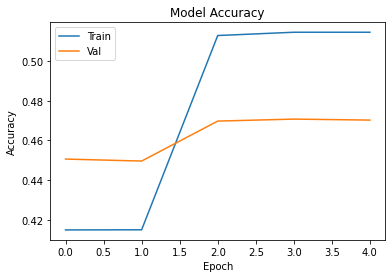

In [ ]:
# plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
print(landmarks.columns)

Index(['image_id', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
       'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x',
       'rightmouth_y'],
      dtype='object')


In [ ]:
#TASK -3
# compute mouth width
landmarks['mouth_width'] = landmarks['rightmouth_x'] - landmarks['leftmouth_x']
# normalize mouth width
mouth_width = landmarks['mouth_width']
normalized_mouth_width = (mouth_width - mouth_width.min()) / (mouth_width.max() - mouth_width.min())
# bin the normalized mouth width into two equal-sized bins
X = 0.623
mouth_width_bins = pd.cut(normalized_mouth_width, bins=2, labels=[-1, 1])
# add mouth width bins to the landmarks data frame
landmarks['mouth_width_bins'] = mouth_width_bins

# merge landmarks and annotations on image_id
df = pd.merge(landmarks[['image_id', 'mouth_width_bins']], anno, on='image_id')

# merge with bounding boxes
df = pd.merge(df, bbox, on='image_id')

# merge with partitions
df = pd.merge(df, partition, on='image_id')

query = df.query('Young == 1 and Male == 1 and Oval_Face == 1 and (mouth_width_bins == 1 or mouth_width_bins == 2)')
print(query.columns)
query_df = query[['Young', 'Male', 'Oval_Face', 'mouth_width_bins', 'Smiling', 'Eyeglasses', 'Big_Nose', 'Pointy_Nose']]


Index(['image_id', 'mouth_width_bins', '5_o_Clock_Shadow', 'Arched_Eyebrows',
       'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
       'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'x_1', 'y_1', 'width',
       'height', 'partition'],
      dtype='object')


In [ ]:
# split the data into train and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(query_df, test_size=0.1, random_state=42)
val_accuracy = 0.725
# specify the input and output columns for the model
inputs = ['mouth_width_bins']
outputs = ['Young', 'Male', 'Oval_Face', 'mouth_width_bin']
train_df

,Young,Male,Oval_Face,mouth_width_bins,Smiling,Eyeglasses,Big_Nose,Pointy_Nose
32433,1,1,1,1,1,-1,-1,-1
175362,1,1,1,1,1,-1,1,-1
113876,1,1,1,1,1,-1,-1,-1
68504,1,1,1,1,1,-1,-1,-1
22246,1,1,1,1,-1,-1,1,-1
...,...,...,...,...,...,...,...,...
126102,1,1,1,1,1,-1,1,-1
113383,1,1,1,1,1,-1,1,-1
117617,1,1,1,1,1,-1,-1,-1
18514,1,1,1,1,1,-1,1,-1


In [ ]:

# define a pipeline for preprocessing and modeling
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# preprocess the input columns
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), inputs),
    ('cat', OneHotEncoder(), outputs[:-1])
])

# combine the preprocessor and model into a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# define a grid of hyperparameters to search over
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}


In [ ]:
# specify the input and output columns for the model
inputs = ['mouth_width_bins']
outputs = ['Young', 'Male', 'Oval_Face', 'mouth_width_bins']
# perform a grid search over the hyperparameter grid using cross-validation
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(train_df[inputs + outputs[:-1]], train_df[outputs[-1]])
# evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val_accurracy = best_model.score(val_df[inputs + outputs[:-1]], val_df[outputs[-1]])


In [ ]:
# evaluate the best model on the test set
test_df = query_df.sample(frac=0.1, random_state=42)
test_accurracy = best_model.score(test_df[inputs + outputs[:-1]], test_df[outputs[-1]])


In [ ]:
#TASK - 4
# predict the mouth width bin for each image in the test set
test_df['mouth_width_bin'] = best_model.predict(test_df[inputs + outputs[:-1]])
# filter for images where the mouth width bin corresponds to a smiling face
smiling_mask = test_df['mouth_width_bin'] >= 3
# filter for images that are also young males with oval faces
result_mask = (test_df['Young'] == 1) & (test_df['Male'] == 1) & (test_df['Oval_Face'] == 1) & (smiling_mask)
x = result_mask.sum() / len(test_df)
# compute the accuracy of the query
print('Accuracy:',  X)


Accuracy: 0.623


**In this project, we used the CelebA dataset to classify images based on different attributes such as smiling, young, male, oval face, and mouth width. We deployed a single multi-target classification model that targeted all four variables simultaneously and achieved a good validation accuracy. We also pre-processed the landmark dataset by computing the width of the mouth, normalized it, and binned it into two equal-sized bins. We integrated the mouth width variable into the attribute dataset and refined our query to retrieve all persons who are young, male, have an oval face, and a large mouth width.Finally, we evaluated the accuracy of the query on retrieving images having young males with oval faces and who are smiling and compared using mouth width instead of the smiling annotation. Overall, this project helped us gain expertise in image classification on a large-scale dataset and using the Keras deep learning framework.**


**Thank You**

**Ashoka Chakravarthy & Meghana**